<a href="https://colab.research.google.com/github/punchnami/AI-Powered-Research-Query-Chatbot/blob/main/predictive_model_arimax_v2_seasonality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [ ]:
import glob, matplotlib.pyplot as plt, numpy as np, os, pandas as pd, seaborn as sns, warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

# Data Cleaning & Merging

## Search

In [ ]:
search_file_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/1. BGCR; SOFR/Search.xlsx'
df = pd.read_excel(search_file_path)
df_cleaned = df.dropna(axis=1, how='all')
df_cleaned = df_cleaned.drop(columns=['Footnote ID'])
df_cleaned = df_cleaned[df_cleaned['Rate Type'] == 'BGCR']
df_BGCR = df_cleaned.copy()
df_BGCR = df_BGCR.rename(columns={'Effective Date': 'Date'})

## Daily Treasury Rates Sheet

In [ ]:
d_treas_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/2 3. Treasury Yield; Yield Spread; Federal'
files_to_concatenate = [
    'daily-treasury-rates_2018.csv',
    'daily-treasury-rates_2019.csv',
    'daily-treasury-rates_2020.csv',
    'daily-treasury-rates_2021.csv',
    'daily-treasury-rates_2022.csv',
    'daily-treasury-rates_2023.csv',
    'daily-treasury-rates_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_rates = merged_df.copy()

## Daily Treasury Rates LT Sheet

In [ ]:
files_to_concatenate = [
    'daily-treasury-rates_LT_2018.csv',
    'daily-treasury-rates_LT_2019.csv',
    'daily-treasury-rates_LT_2020.csv',
    'daily-treasury-rates_LT_2021.csv',
    'daily-treasury-rates_LT_2022.csv',
    'daily-treasury-rates_LT_2023.csv',
    'daily-treasury-rates_LT_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_LT_rates = merged_df.copy()

df_merged = pd.merge(merged_daily_treasury_rates, merged_daily_treasury_LT_rates, on='Date', how='inner')

## Feature Additions

In [ ]:
# Calculate short-term yield spreads
df_merged['Yield Spread (4W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (13W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['13 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (26W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['26 WEEKS COUPON EQUIVALENT']

# Calculate long-term yield spreads
df_merged['Yield Spread (10Y - 4W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 4W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (10Y - 52W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['52 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 52W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['52 WEEKS COUPON EQUIVALENT']

## Columns to Keep

In [ ]:
columns_to_keep = [
    'Date',
    '4 WEEKS COUPON EQUIVALENT',
    '13 WEEKS COUPON EQUIVALENT',
    '26 WEEKS COUPON EQUIVALENT',
    '52 WEEKS COUPON EQUIVALENT',
    'LT COMPOSITE (>10 Yrs)',
    'TREASURY 20-Yr CMT',
    'Yield Spread (4W - 52W)',
    'Yield Spread (13W - 52W)',
    'Yield Spread (26W - 52W)',
    'Yield Spread (10Y - 4W)',
    'Yield Spread (20Y - 4W)',
    'Yield Spread (10Y - 52W)',
    'Yield Spread (20Y - 52W)'
]
df_relevant = df_merged[columns_to_keep]

df_merged = pd.merge(df_BGCR, df_relevant, on='Date', how='inner')
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

## Add CPI

In [ ]:
cpi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [247.867, 251.712, 257.971, 261.582, 281.148, 299.170, 308.417],
    'Feb': [248.991, 252.776, 258.678, 263.014, 283.716, 300.840, 310.326],
    'Mar': [249.554, 254.202, 258.115, 264.877, 287.504, 301.836, 312.332],
    'Apr': [250.546, 255.548, 256.389, 267.054, 289.109, 303.363, 313.548],
    'May': [251.588, 256.092, 256.934, 269.195, 292.296, 304.127, 314.069],
    'Jun': [251.988, 256.143, 257.797, 271.696, 296.311, 305.109, 314.069],
    'Jul': [252.006, 256.571, 259.101, 273.003, 296.276, 305.691, None],
    'Aug': [252.146, 256.558, 259.918, 273.567, 296.171, 307.026, None],
    'Sep': [252.439, 256.759, 260.280, 274.310, 296.908, 307.789, None],
    'Oct': [252.885, 257.346, 260.388, 276.589, 298.012, 307.671, None],
    'Nov': [252.038, 257.346, 260.229, 277.948, 297.711, 307.051, None],
    'Dec': [251.233, 257.208, 260.474, 278.802, 296.797, 306.746, None]
}


cpi_df = pd.DataFrame(cpi_data)
cpi_long_df = pd.melt(cpi_df, id_vars=['Year'], var_name='Month', value_name='CPI')
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
cpi_long_df['Month'] = cpi_long_df['Month'].map(month_mapping)
cpi_long_df['Day'] = 1
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df[['Year', 'Month', 'Day']])
cpi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
cpi_long_df.set_index('Date', inplace=True)
cpi_long_df = cpi_long_df.resample('D').ffill()
cpi_long_df.reset_index(inplace=True)
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df['Date'])

df_merged2 = pd.merge(df_merged, cpi_long_df[['Date', 'CPI']], on='Date', how='left')

## Add SPX

In [ ]:
spx_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719610851813_SPX.csv'
df = pd.read_csv(spx_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'SPX'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged3 = pd.merge(df_merged2, df, on='Date', how='inner')

## Add NASDAQ

In [ ]:
nasdaq_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719611009685_COMP.csv'
df = pd.read_csv(nasdaq_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'NASDAQ'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged4 = pd.merge(df_merged3, df, on='Date', how='inner')

## Add DJIA

In [ ]:
djia_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalPrices_DJIA.csv'
df = pd.read_csv(djia_path)
df = df.drop(columns=[' Open', ' High', ' Low'], axis=1)
df = df.rename(columns={' Close': 'DJIA'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged5 = pd.merge(df_merged4, df, on='Date', how='inner')

<ipython-input-14-884830d5858d>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


## Add ForEx

In [ ]:
forex_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/7. FX/FRB_H10.csv'
df = pd.read_csv(forex_path)
df = df.iloc[5:]
df.rename(columns={'Series Description': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df_merged6 = pd.merge(df_merged5, df, on='Date', how='inner')

## Other Feature Engineering

In [ ]:
df_final = df_merged6.copy()
df_final = df_final.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)'])

# Set the 'Date' column as the index
df_final.set_index('Date', inplace=True)
df_final2 = df_final.sort_index(ascending=True)
df_final2

# Replace 'ND' with NaN and fill with a method or drop rows
df_final2.replace('ND', np.nan, inplace=True)

# Drop rows with NaN values in the dataframe
df_final2.dropna(inplace=True)

# Convert columns to float
cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_final2[cols] = df_final2[cols].astype(float)

### VIF Before Differencing

In [ ]:
# Define the VIF function
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

In [ ]:
# Calculate VIF before differencing to understand the multicollinearity in the original data
print("VIF before differencing:")
vif_before = calculate_vif(df_final2.drop(columns=['Rate (%)']))
# print(vif_before)
round(vif_before, 4)

VIF before differencing:


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Feature,VIF
0,Volume ($Billions),248.3028
1,4 WEEKS COUPON EQUIVALENT,inf
2,13 WEEKS COUPON EQUIVALENT,inf
3,26 WEEKS COUPON EQUIVALENT,inf
4,52 WEEKS COUPON EQUIVALENT,inf
5,LT COMPOSITE (>10 Yrs),inf
6,TREASURY 20-Yr CMT,inf
7,Yield Spread (4W - 52W),inf
8,Yield Spread (13W - 52W),inf
9,Yield Spread (26W - 52W),inf


### Stationarity Check

In [ ]:
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out['Critical Value (%s)' % key] = value
    print(f'===Augmented Dickey-Fuller Test: {title}===')
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary")

def kpss_test(series, title=''):
    result = kpss(series.dropna(), regression='c')
    labels = ['KPSS Test Statistic', 'p-value', '#Lags Used']
    out = pd.Series(result[0:3], index=labels)
    for key, value in result[3].items():
        out['Critical Value (%s)' % key] = value
    print(f'===KPSS Test: {title}===')
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary")
    else:
        print("Weak evidence against the null hypothesis, time series is stationary")

In [ ]:
df_stationary = df_final2.copy()

# Function to check stationarity and apply differencing
def ensure_stationarity(series, name):
    try:
        print(f"\nChecking stationarity for {name}:\n")
        adf_test(series, title=name)
        print("\n")
        kpss_test(series, title=name)

        # Check stationarity after the first differencing if necessary
        if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
            print(f"\n{name} is not stationary. Applying first differencing.\n")
            series = series.diff().dropna()

            # Ensure no infinite or NaN values
            if np.isinf(series).any() or series.isna().any():
                series.replace([np.inf, -np.inf], np.nan, inplace=True)
                series.dropna(inplace=True)

            print(f"\nRe-checking stationarity for {name} after first differencing:\n")
            adf_test(series, title=f"{name} - First Differenced")
            print("\n")
            kpss_test(series, title=f"{name} - First Differenced")

            # Check stationarity after the second differencing if necessary
            if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
                print(f"\n{name} is still not stationary. Applying second differencing.\n")
                series = series.diff().dropna()

                # Ensure no infinite or NaN values
                if np.isinf(series).any() or series.isna().any():
                    series.replace([np.inf, -np.inf], np.nan, inplace=True)
                    series.dropna(inplace=True)

                print(f"\nRe-checking stationarity for {name} after second differencing:\n")
                adf_test(series, title=f"{name} - Second Differenced")
                print("\n")
                kpss_test(series, title=f"{name} - Second Differenced")
            else:
                print(f"\n{name} is stationary after first differencing.\n")
        else:
            print(f"{name} is already stationary.\n")
    except Exception as e:
        print(f"An error occurred while processing {name}: {e}")

    return series

# Apply the function to each explanatory variable
for col in df_stationary.columns:
    if col not in ['Rate (%)', 'Rate (%) - First Differenced', 'Rate (%) - Second Differenced']:
        df_stationary[col] = ensure_stationarity(df_final2[col], col)

# Now, let's ensure the 'Rate (%)' column is also stationary, applying the same procedure
df_stationary['Rate (%)'] = ensure_stationarity(df_final2['Rate (%)'], 'Rate (%)')

print("Stationarity check and differencing completed.")


Checking stationarity for Volume ($Billions):

===Augmented Dickey-Fuller Test: Volume ($Billions)===
ADF Test Statistic                0.776581
p-value                           0.991249
#Lags Used                       13.000000
Number of Observations Used    1534.000000
Critical Value (1%)              -3.434620
Critical Value (5%)              -2.863426
Critical Value (10%)             -2.567774
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Volume ($Billions)===
KPSS Test Statistic       2.145532
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Volume ($Billions) is not stationary. Applying first differencing.


Re-checking stationarity for Volume ($Billi

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Volume ($Billions) - First Differenced===
ADF Test Statistic            -1.265209e+01
p-value                        1.361381e-23
#Lags Used                     1.200000e+01
Number of Observations Used    1.534000e+03
Critical Value (1%)           -3.434620e+00
Critical Value (5%)           -2.863426e+00
Critical Value (10%)          -2.567774e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Volume ($Billions) - First Differenced===
KPSS Test Statistic       0.381913
p-value                   0.084951
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Volume ($Billions) is stationary after first differencing.


Checking stationarity for 4 WEEKS COUPON EQUIVALENT:

===Augmented Dic

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



4 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 4 WEEKS COUPON EQUIVALENT after first differencing:

===Augmented Dickey-Fuller Test: 4 WEEKS COUPON EQUIVALENT - First Differenced===
ADF Test Statistic            -7.201498e+00
p-value                        2.358997e-10
#Lags Used                     2.400000e+01
Number of Observations Used    1.522000e+03
Critical Value (1%)           -3.434654e+00
Critical Value (5%)           -2.863441e+00
Critical Value (10%)          -2.567782e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 4 WEEKS COUPON EQUIVALENT - First Differenced===
KPSS Test Statistic       0.597240
p-value                   0.022887
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the 

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Weak evidence against the null hypothesis, time series is stationary

Checking stationarity for 13 WEEKS COUPON EQUIVALENT:

===Augmented Dickey-Fuller Test: 13 WEEKS COUPON EQUIVALENT===
ADF Test Statistic                0.063587
p-value                           0.963485
#Lags Used                       22.000000
Number of Observations Used    1525.000000
Critical Value (1%)              -3.434645
Critical Value (5%)              -2.863437
Critical Value (10%)             -2.567780
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: 13 WEEKS COUPON EQUIVALENT===
KPSS Test Statistic       2.885025
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

13 WEEKS COUPON EQ

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: 13 WEEKS COUPON EQUIVALENT - Second Differenced===
ADF Test Statistic            -1.321278e+01
p-value                        1.038910e-24
#Lags Used                     2.200000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 13 WEEKS COUPON EQUIVALENT - Second Differenced===
KPSS Test Statistic       0.013801
p-value                   0.100000
#Lags Used               28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Checking stationarity for 26 WEEKS COUPON EQUIVALENT:

===Augmented Dickey-Fuller Test: 26 WEEKS COUPON EQUIVALEN

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



26 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 26 WEEKS COUPON EQUIVALENT after first differencing:

===Augmented Dickey-Fuller Test: 26 WEEKS COUPON EQUIVALENT - First Differenced===
ADF Test Statistic            -5.903553e+00
p-value                        2.742054e-07
#Lags Used                     1.900000e+01
Number of Observations Used    1.527000e+03
Critical Value (1%)           -3.434640e+00
Critical Value (5%)           -2.863435e+00
Critical Value (10%)          -2.567779e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 26 WEEKS COUPON EQUIVALENT - First Differenced===
KPSS Test Statistic       0.950733
p-value                   0.010000
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against 

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



26 WEEKS COUPON EQUIVALENT is still not stationary. Applying second differencing.


Re-checking stationarity for 26 WEEKS COUPON EQUIVALENT after second differencing:

===Augmented Dickey-Fuller Test: 26 WEEKS COUPON EQUIVALENT - Second Differenced===
ADF Test Statistic            -1.521944e+01
p-value                        5.511491e-28
#Lags Used                     1.800000e+01
Number of Observations Used    1.527000e+03
Critical Value (1%)           -3.434640e+00
Critical Value (5%)           -2.863435e+00
Critical Value (10%)          -2.567779e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 26 WEEKS COUPON EQUIVALENT - Second Differenced===
KPSS Test Statistic       0.005815
p-value                   0.100000
#Lags Used               16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence 

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: 52 WEEKS COUPON EQUIVALENT===
ADF Test Statistic               -0.111524
p-value                           0.948279
#Lags Used                       22.000000
Number of Observations Used    1525.000000
Critical Value (1%)              -3.434645
Critical Value (5%)              -2.863437
Critical Value (10%)             -2.567780
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: 52 WEEKS COUPON EQUIVALENT===
KPSS Test Statistic       2.938602
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

52 WEEKS COUPON EQUIVALENT is not stationary. Applying first differencing.


Re-checking stationarity for 52 WEEKS COUPON EQUIVALENT after first

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:


===Augmented Dickey-Fuller Test: 52 WEEKS COUPON EQUIVALENT - Second Differenced===
ADF Test Statistic            -1.478560e+01
p-value                        2.211103e-27
#Lags Used                     2.000000e+01
Number of Observations Used    1.525000e+03
Critical Value (1%)           -3.434645e+00
Critical Value (5%)           -2.863437e+00
Critical Value (10%)          -2.567780e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: 52 WEEKS COUPON EQUIVALENT - Second Differenced===
KPSS Test Statistic       0.016947
p-value                   0.100000
#Lags Used               50.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypothesis, time series is stationary

Checking stationarity for LT COMPOSITE (>10 Yrs):

===Augmented Dickey-Fuller Test: LT COMPOSITE (>10 Yrs)===
ADF

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



LT COMPOSITE (>10 Yrs) is not stationary. Applying first differencing.


Re-checking stationarity for LT COMPOSITE (>10 Yrs) after first differencing:

===Augmented Dickey-Fuller Test: LT COMPOSITE (>10 Yrs) - First Differenced===
ADF Test Statistic              -29.642217
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1545.000000
Critical Value (1%)              -3.434590
Critical Value (5%)              -2.863413
Critical Value (10%)             -2.567767
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: LT COMPOSITE (>10 Yrs) - First Differenced===
KPSS Test Statistic      0.312068
p-value                  0.100000
#Lags Used               1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



LT COMPOSITE (>10 Yrs) is stationary after first differencing.


Checking stationarity for TREASURY 20-Yr CMT:

===Augmented Dickey-Fuller Test: TREASURY 20-Yr CMT===
ADF Test Statistic               -0.307270
p-value                           0.924468
#Lags Used                        2.000000
Number of Observations Used    1545.000000
Critical Value (1%)              -3.434590
Critical Value (5%)              -2.863413
Critical Value (10%)             -2.567767
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: TREASURY 20-Yr CMT===
KPSS Test Statistic       3.25098
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



TREASURY 20-Yr CMT is not stationary. Applying first differencing.


Re-checking stationarity for TREASURY 20-Yr CMT after first differencing:

===Augmented Dickey-Fuller Test: TREASURY 20-Yr CMT - First Differenced===
ADF Test Statistic              -29.726862
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1545.000000
Critical Value (1%)              -3.434590
Critical Value (5%)              -2.863413
Critical Value (10%)             -2.567767
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: TREASURY 20-Yr CMT - First Differenced===
KPSS Test Statistic      0.311121
p-value                  0.100000
#Lags Used               0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary


<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



TREASURY 20-Yr CMT is stationary after first differencing.


Checking stationarity for Yield Spread (4W - 52W):

===Augmented Dickey-Fuller Test: Yield Spread (4W - 52W)===
ADF Test Statistic               -1.761954
p-value                           0.399507
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (4W - 52W)===
KPSS Test Statistic       0.552794
p-value                   0.029776
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (4W - 52W) is not stati

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



Yield Spread (4W - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (13W - 52W):

===Augmented Dickey-Fuller Test: Yield Spread (13W - 52W)===
ADF Test Statistic               -1.765429
p-value                           0.397755
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (13W - 52W)===
KPSS Test Statistic       0.551603
p-value                   0.030044
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (13W - 52W) is 

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



Yield Spread (13W - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (26W - 52W):

===Augmented Dickey-Fuller Test: Yield Spread (26W - 52W)===
ADF Test Statistic               -1.797696
p-value                           0.381606
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (26W - 52W)===
KPSS Test Statistic       1.076525
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (26W - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (26W - 52W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (26W - 52W) - First Differenced===
ADF Test Statistic            -8.362724e+00
p-value                        2.795353e-13
#Lags Used                     2.200000e+01
Number of Observations Used    1.524000e+03
Critical Value (1%)           -3.434648e+00
Critical Value (5%)           -2.863438e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (26W - 52W) - First Differenced===
KPSS Test Statistic       0.065045
p-value                   0.100000
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null h

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



Yield Spread (26W - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (10Y - 4W):

===Augmented Dickey-Fuller Test: Yield Spread (10Y - 4W)===
ADF Test Statistic               -0.991309
p-value                           0.756421
#Lags Used                       24.000000
Number of Observations Used    1523.000000
Critical Value (1%)              -3.434651
Critical Value (5%)              -2.863440
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (10Y - 4W)===
KPSS Test Statistic       1.74669
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (10Y - 4W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (10Y - 4W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (10Y - 4W) - First Differenced===
ADF Test Statistic            -8.381766e+00
p-value                        2.499047e-13
#Lags Used                     2.300000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (10Y - 4W) - First Differenced===
KPSS Test Statistic       0.133822
p-value                   0.100000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Weak evidence against the null hypot

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:



Yield Spread (10Y - 4W) is stationary after first differencing.


Checking stationarity for Yield Spread (20Y - 4W):

===Augmented Dickey-Fuller Test: Yield Spread (20Y - 4W)===
ADF Test Statistic               -0.999176
p-value                           0.753565
#Lags Used                       24.000000
Number of Observations Used    1523.000000
Critical Value (1%)              -3.434651
Critical Value (5%)              -2.863440
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (20Y - 4W)===
KPSS Test Statistic       1.579764
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary


<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (20Y - 4W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (20Y - 4W) after first differencing:

===Augmented Dickey-Fuller Test: Yield Spread (20Y - 4W) - First Differenced===
ADF Test Statistic            -8.370157e+00
p-value                        2.675730e-13
#Lags Used                     2.300000e+01
Number of Observations Used    1.523000e+03
Critical Value (1%)           -3.434651e+00
Critical Value (5%)           -2.863440e+00
Critical Value (10%)          -2.567781e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: Yield Spread (20Y - 4W) - First Differenced===
KPSS Test Statistic       0.13947
p-value                   0.10000
#Lags Used               17.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Weak evidence against the null hypothesis, 

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: Yield Spread (10Y - 52W)===
ADF Test Statistic               -0.675197
p-value                           0.853070
#Lags Used                        4.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (10Y - 52W)===
KPSS Test Statistic       2.256507
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (10Y - 52W) is not stationary. Applying first differencing.


Re-checking stationarity for Yield Spread (10Y - 52W) after first differe

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (10Y - 52W) is stationary after first differencing.


Checking stationarity for Yield Spread (20Y - 52W):

===Augmented Dickey-Fuller Test: Yield Spread (20Y - 52W)===
ADF Test Statistic               -0.677646
p-value                           0.852455
#Lags Used                        4.000000
Number of Observations Used    1543.000000
Critical Value (1%)              -3.434595
Critical Value (5%)              -2.863415
Critical Value (10%)             -2.567768
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Yield Spread (20Y - 52W)===
KPSS Test Statistic       2.040066
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Yield Spread (20Y - 52W) is

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



Yield Spread (20Y - 52W) is stationary after first differencing.


Checking stationarity for CPI:

===Augmented Dickey-Fuller Test: CPI===
ADF Test Statistic                0.625158
p-value                           0.988220
#Lags Used                       23.000000
Number of Observations Used    1524.000000
Critical Value (1%)              -3.434648
Critical Value (5%)              -2.863438
Critical Value (10%)             -2.567781
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: CPI===
KPSS Test Statistic       5.8641
p-value                   0.0100
#Lags Used               25.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

CPI is not stationary. Applying first differencing.


Re-checking stationarity for CPI after first diffe

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2171: RuntimeWarning: divide by zero encountered in scalar divide
  s_hat = s1 / s0
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



SPX is not stationary. Applying first differencing.


Re-checking stationarity for SPX after first differencing:

===Augmented Dickey-Fuller Test: SPX - First Differenced===
ADF Test Statistic            -1.219072e+01
p-value                        1.287629e-22
#Lags Used                     8.000000e+00
Number of Observations Used    1.538000e+03
Critical Value (1%)           -3.434609e+00
Critical Value (5%)           -2.863421e+00
Critical Value (10%)          -2.567771e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: SPX - First Differenced===
KPSS Test Statistic      0.073802
p-value                  0.100000
#Lags Used               0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

SPX is stationary after first differencing.


Checkin

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: NASDAQ===
ADF Test Statistic               -0.461922
p-value                           0.899235
#Lags Used                        9.000000
Number of Observations Used    1538.000000
Critical Value (1%)              -3.434609
Critical Value (5%)              -2.863421
Critical Value (10%)             -2.567771
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: NASDAQ===
KPSS Test Statistic       4.37819
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

NASDAQ is not stationary. Applying first differencing.


Re-checking stationarity for NASDAQ after first differencing:

===Augmented Dickey-Fuller Test: NASDAQ - First Differenced===
ADF Test

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: DJIA===
ADF Test Statistic               -1.223282
p-value                           0.663501
#Lags Used                        9.000000
Number of Observations Used    1538.000000
Critical Value (1%)              -3.434609
Critical Value (5%)              -2.863421
Critical Value (10%)             -2.567771
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: DJIA===
KPSS Test Statistic       4.897202
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

DJIA is not stationary. Applying first differencing.


Re-checking stationarity for DJIA after first differencing:

===Augmented Dickey-Fuller Test: DJIA - First Differenced===
ADF Test St

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: SPOT EXCHANGE RATE - EURO AREA  - First Differenced===
ADF Test Statistic            -1.748117e+01
p-value                        4.488492e-30
#Lags Used                     5.000000e+00
Number of Observations Used    1.541000e+03
Critical Value (1%)           -3.434601e+00
Critical Value (5%)           -2.863417e+00
Critical Value (10%)          -2.567769e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: SPOT EXCHANGE RATE - EURO AREA  - First Differenced===
KPSS Test Statistic      0.087167
p-value                  0.100000
#Lags Used               2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

SPOT EXCHANGE RATE - EURO AREA  is stationary after first differencing.


Checking stationarity for UNITED KINGD

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


===Augmented Dickey-Fuller Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced===
ADF Test Statistic            -1.243071e+01
p-value                        3.946348e-23
#Lags Used                     1.000000e+01
Number of Observations Used    1.536000e+03
Critical Value (1%)           -3.434614e+00
Critical Value (5%)           -2.863424e+00
Critical Value (10%)          -2.567773e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced===
KPSS Test Statistic      0.072704
p-value                  0.100000
#Lags Used               4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
Weak evidence against the null hypothesis, time series is stationary

UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  is not stationary. Applying first differencing.


Re-checking stationarity for CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  after first differencing:

===Augmented Dickey-Fuller Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced===
ADF Test Statistic            -1.815930e+01
p-value                        2.463800e-30
#Lags Used                     3.000000e+00
Number of Observations Used    1.543000e+03
Critical Value (1%)           -3.434595e+00
Critical Value (5%)           -2.863415e+00
Critical Value (10%)          -2.567768e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


===KPSS Test: CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced===
KPSS Test Statistic      0.183514
p-value                  0.100000
#Lags Used               9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.5740

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



KPSS Test Statistic       4.756523
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

JAPAN -- SPOT EXCHANGE RATE, YEN/US$  is not stationary. Applying first differencing.


Re-checking stationarity for JAPAN -- SPOT EXCHANGE RATE, YEN/US$  after first differencing:

===Augmented Dickey-Fuller Test: JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced===
ADF Test Statistic              -24.439407
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1544.000000
Critical Value (1%)              -3.434592
Critical Value (5%)              -2.863414
Critical Value (10%)             -2.567768
Strong evidence against the null hypothesis, reject the null hypothesis. Data ha

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-622013a18d5a>:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  if adfuller(series.dropna())[1] > 0.05 or kpss(series.dropna(), regression='c')[1] <= 0.05:
<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')



JAPAN -- SPOT EXCHANGE RATE, YEN/US$  is stationary after first differencing.


Checking stationarity for Rate (%):

===Augmented Dickey-Fuller Test: Rate (%)===
ADF Test Statistic                0.509674
p-value                           0.985164
#Lags Used                        9.000000
Number of Observations Used    1538.000000
Critical Value (1%)              -3.434609
Critical Value (5%)              -2.863421
Critical Value (10%)             -2.567771
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


===KPSS Test: Rate (%)===
KPSS Test Statistic       2.705655
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Strong evidence against the null hypothesis, reject the null hypothesis. Data is not-stationary

Rate (%) is not stationary. Applying first differencing.


Re-

<ipython-input-16-ce838f25dfc8>:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


### Creating Lagged & Difference Features

In [ ]:
# Define a function to create lag features
def create_lag_features(df, lags, cols):
    for col in cols:
        for lag in lags:
            df[f'{col} - Lag{lag}'] = df[col].shift(lag)
    return df

# Define a function to create differenced features
def create_differenced_features(df, cols_for_first_diff, cols_for_second_diff):
    for col in cols_for_first_diff:
        df[f'{col} - First Differenced'] = df[col].diff()
    for col in cols_for_second_diff:
        df[f'{col} - Second Differenced'] = df[col].diff().diff()
    return df

# Apply differencing and lag feature creation to the DataFrame
def prepare_features(df, cols_for_first_diff, cols_for_second_diff):
    # Columns for which lag features will be created
    cols_for_lags = list(set(df.columns) - set(cols_for_first_diff + cols_for_second_diff))
    cols_for_lags += cols_for_first_diff + cols_for_second_diff  # Ensure all relevant columns are included

    # Create differenced features
    df = create_differenced_features(df, cols_for_first_diff, cols_for_second_diff)

    # Create lag features
    lags = [1, 2, 3, 7, 14]  # Adjust the list of lags based on your needs
    df = create_lag_features(df, lags, cols_for_lags)

    # Drop rows with NaN values created by differencing and lagging
    df.dropna(inplace=True)

    return df

# Specify the columns for first and second differencing
cols_for_first_diff = ['Volume ($Billions)','LT COMPOSITE (>10 Yrs)','TREASURY 20-Yr CMT',
                       'Yield Spread (4W - 52W)','Yield Spread (13W - 52W)','Yield Spread (26W - 52W)',
                       'Yield Spread (10Y - 4W)','Yield Spread (20Y - 4W)','Yield Spread (10Y - 52W)',
                       'Yield Spread (20Y - 52W)','SPX','NASDAQ','DJIA','SPOT EXCHANGE RATE - EURO AREA ',
                       'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)','CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ',
                       'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']  # Replace with actual column names that need first differencing

cols_for_second_diff = ['4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT',
                        '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT',
                        'CPI', 'Rate (%)']  # Replace with actual column names that need second differencing

# Prepare the features
df_prepared = prepare_features(df_final2.copy(), cols_for_first_diff, cols_for_second_diff)

print("Feature preparation (differencing and lag features) completed.\n\n")
df_prepared.head()

<ipython-input-22-23e968d9d660>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-22-23e968d9d660>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col} - Lag{lag}'] = df[col].shift(lag)
<ipython-input-22-23e968d9d660>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, 

Feature preparation (differencing and lag features) completed.




,Rate (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,26 WEEKS COUPON EQUIVALENT,52 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Yield Spread (4W - 52W),Yield Spread (13W - 52W),...,CPI - Lag1,CPI - Lag2,CPI - Lag3,CPI - Lag7,CPI - Lag14,Rate (%) - Lag1,Rate (%) - Lag2,Rate (%) - Lag3,Rate (%) - Lag7,Rate (%) - Lag14
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-20,1.67,340,1.64,1.81,2.01,2.20,3.09,3.04,0.56,0.39,...,250.546,250.546,250.546,250.546,250.546,1.67,1.69,1.70,1.70,1.77
2018-04-23,1.67,348,1.66,1.87,2.04,2.22,3.10,3.05,0.56,0.35,...,250.546,250.546,250.546,250.546,250.546,1.67,1.67,1.69,1.68,1.81
2018-04-24,1.68,339,1.70,1.87,2.05,2.25,3.12,3.08,0.55,0.38,...,250.546,250.546,250.546,250.546,250.546,1.67,1.67,1.67,1.68,1.70
2018-04-25,1.67,345,1.64,1.85,2.03,2.26,3.16,3.12,0.62,0.41,...,250.546,250.546,250.546,250.546,250.546,1.68,1.67,1.67,1.70,1.70
2018-04-26,1.67,333,1.61,1.82,2.02,2.25,3.13,3.08,0.64,0.43,...,250.546,250.546,250.546,250.546,250.546,1.67,1.68,1.67,1.70,1.70


### VIF After Differencing

In [ ]:
# Calculate VIF after differencing to understand the multicollinearity in the stationary data
print("VIF after differencing:")
vif_after = calculate_vif(df_prepared.drop(columns=['Rate (%)']))
vif_after

VIF after differencing:


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Feature,VIF
0,Volume ($Billions),inf
1,4 WEEKS COUPON EQUIVALENT,inf
2,13 WEEKS COUPON EQUIVALENT,inf
3,26 WEEKS COUPON EQUIVALENT,inf
4,52 WEEKS COUPON EQUIVALENT,inf
...,...,...
155,Rate (%) - Lag1,2429.485753
156,Rate (%) - Lag2,1832.615424
157,Rate (%) - Lag3,785.939723
158,Rate (%) - Lag7,528.658428


### Correlation Matrix

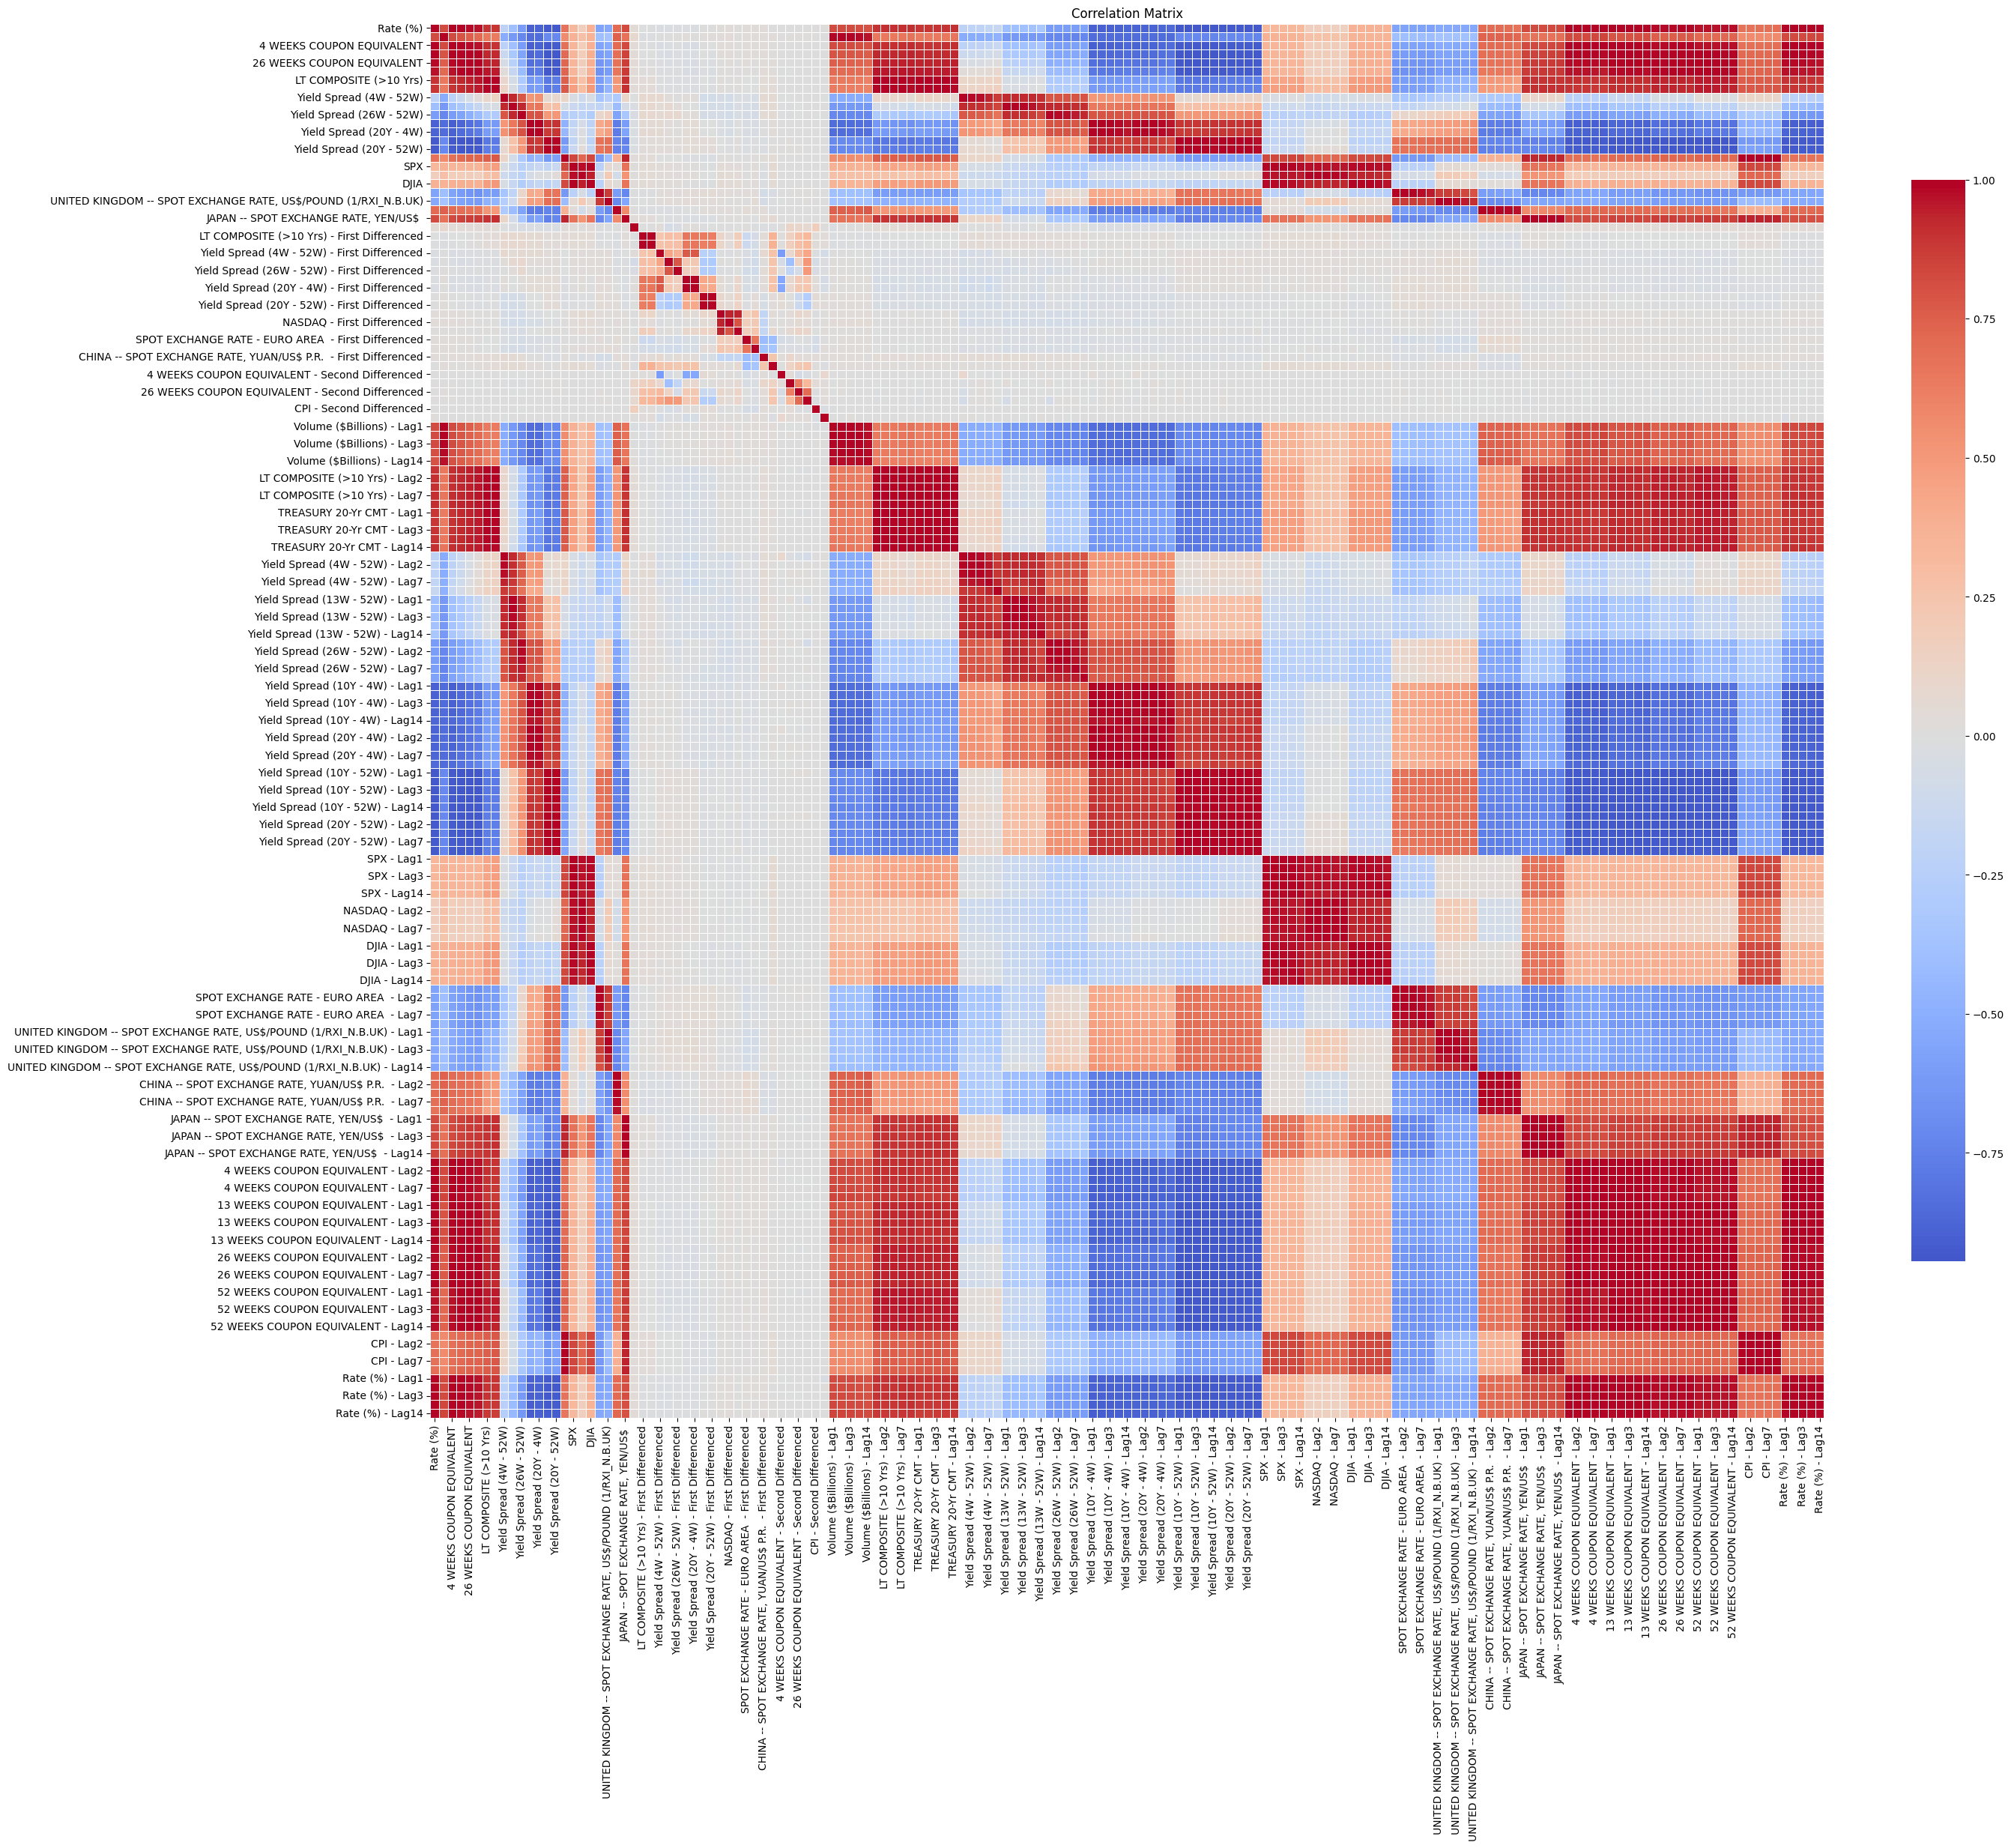

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df_prepared.corr()

# Plot the heatmap
plt.figure(figsize=(30, 25)) #14,12
sns.heatmap(correlation_matrix, annot=False, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .75})
plt.title('Correlation Matrix')
plt.show()

### ADDITIONALS

In [ ]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame with over 130 factors
correlation_matrix = df_prepared.corr().abs()  # Use absolute values to consider both positive and negative correlations

# Print the correlation matrix if needed
# print(correlation_matrix)


In [ ]:
# Create a mask to ignore the diagonal elements (self-correlations)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the mask to the correlation matrix
correlation_matrix = correlation_matrix.mask(mask)

# Set a threshold for high correlations (e.g., 0.8)
high_correlation_threshold = 0.8

# Find pairs of features with correlation above the threshold
high_correlation_pairs = np.where(correlation_matrix > high_correlation_threshold)
high_correlation_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                          for x, y in zip(*high_correlation_pairs) if x != y]

print("Highly correlated pairs of features:")
print(high_correlation_pairs)


Highly correlated pairs of features:
[('Volume ($Billions)', 'Rate (%)'), ('4 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('4 WEEKS COUPON EQUIVALENT', 'Volume ($Billions)'), ('13 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('13 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('26 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('26 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('26 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', 'Rate (%)'), ('52 WEEKS COUPON EQUIVALENT', '4 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT'), ('52 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', 'Rate (%)'), ('LT COMPOSITE (>10 Yrs)', '4 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '13 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '26 WEEKS COUPON EQUIVALENT'), ('LT COMPOSITE (>10 Yrs)', '52 WEEKS COUPON EQUIVALENT'), ('TREASURY 20-Yr CMT', 'Rate (%)'), ('TREASURY 20-Yr CMT',

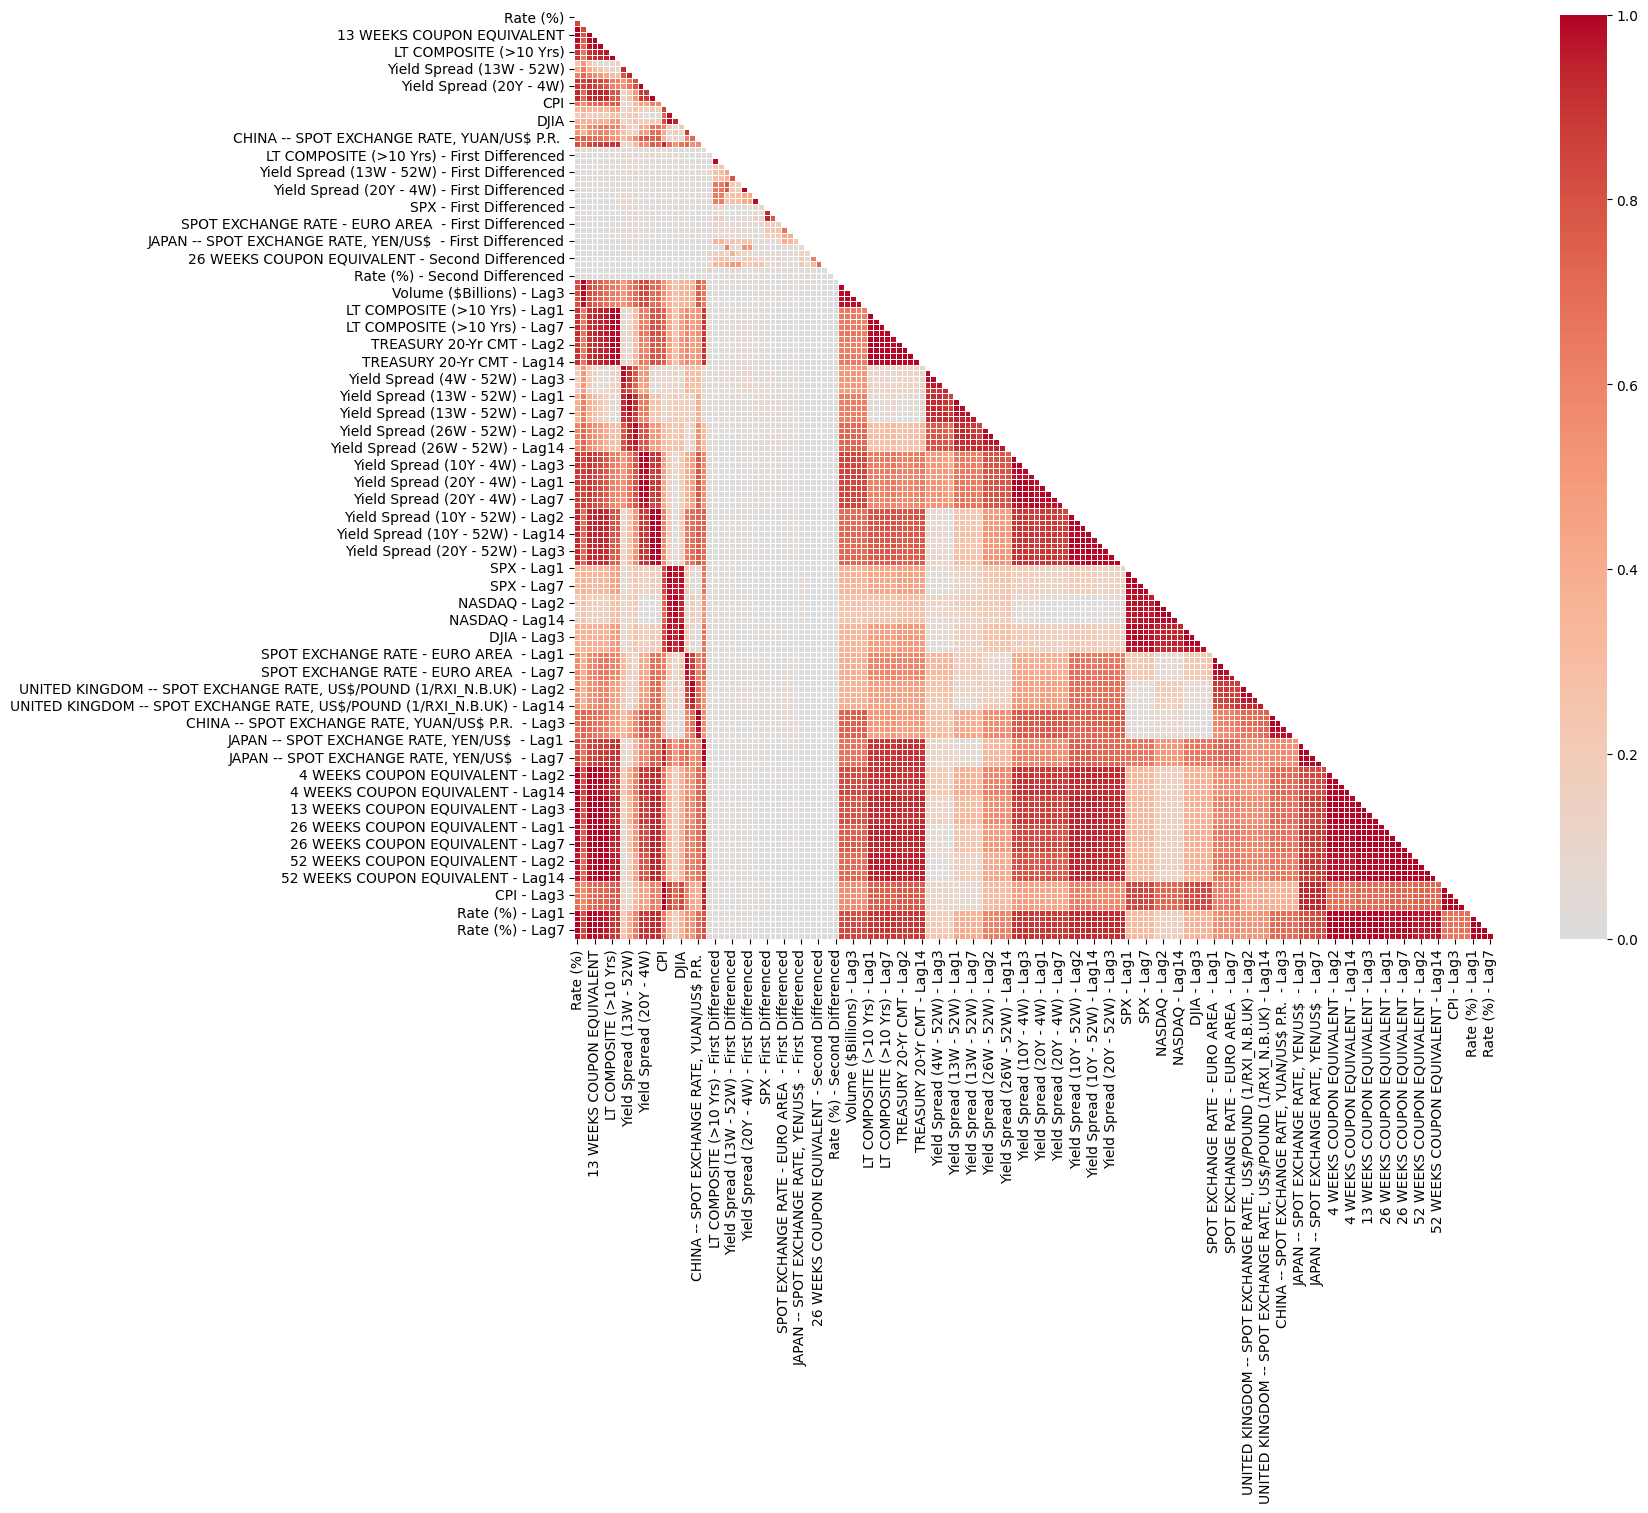

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the heatmap
plt.figure(figsize=(16, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, annot=False, fmt='.2f')

plt.show()


In [ ]:
vif_df = df_prepared.copy()
# Set to keep track of features to drop
features_to_drop = set()

for pair in high_correlation_pairs:
    feature1, feature2 = pair

    # Drop the second feature of the pair
    features_to_drop.add(feature2)

# Drop the features from the DataFrame
df_reduced = vif_df.drop(columns=features_to_drop)

print("Features dropped due to high correlation:")
print(features_to_drop)


Features dropped due to high correlation:
{'NASDAQ', 'NASDAQ - Lag14', '26 WEEKS COUPON EQUIVALENT - Lag14', 'LT COMPOSITE (>10 Yrs) - Lag3', 'Yield Spread (20Y - 4W)', 'Yield Spread (20Y - 52W) - Lag14', '4 WEEKS COUPON EQUIVALENT - Lag1', 'Yield Spread (20Y - 4W) - Lag2', 'Volume ($Billions) - Lag3', 'Yield Spread (13W - 52W) - Lag1', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'SPOT EXCHANGE RATE - EURO AREA  - Lag7', 'Yield Spread (4W - 52W) - Lag14', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - Lag2', 'SPX - Lag1', 'LT COMPOSITE (>10 Yrs) - Lag7', 'Volume ($Billions)', 'Yield Spread (10Y - 52W) - Lag1', 'Yield Spread (4W - 52W) - Lag3', 'Yield Spread (26W - 52W) - Lag2', 'Yield Spread (10Y - 4W) - Lag1', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'Yield Spread (10Y - 4W) - Lag14', 'Yield Spread (10Y - 4W) - Lag2', 'DJIA - Lag1', 'SPX - First Differenced', 'Yield Spread (10Y - 52W) - Lag7', 'Yield Spread (26W - 52W) - Lag1', 'Yield Spread (20Y - 4W) - Lag7', '

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_reduced.values
vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif_df["Variable"] = df_reduced.columns

print("VIF values after handling multicollinearity:")
vif_df

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF values after handling multicollinearity:


/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,VIF,Variable
0,1.055882,Volume ($Billions) - First Differenced
1,7.820905,TREASURY 20-Yr CMT - First Differenced
2,inf,Yield Spread (4W - 52W) - First Differenced
3,7.994006,Yield Spread (13W - 52W) - First Differenced
4,7.536310,Yield Spread (26W - 52W) - First Differenced
5,inf,Yield Spread (20Y - 4W) - First Differenced
6,inf,Yield Spread (20Y - 52W) - First Differenced
7,2.757258,NASDAQ - First Differenced
8,2.919017,DJIA - First Differenced
9,2.041515,SPOT EXCHANGE RATE - EURO AREA - First Differ...


### Drop Columns

In [ ]:
vif_df['Variable'].to_list()

['Volume ($Billions) - First Differenced',
 'TREASURY 20-Yr CMT - First Differenced',
 'Yield Spread (4W - 52W) - First Differenced',
 'Yield Spread (13W - 52W) - First Differenced',
 'Yield Spread (26W - 52W) - First Differenced',
 'Yield Spread (20Y - 4W) - First Differenced',
 'Yield Spread (20Y - 52W) - First Differenced',
 'NASDAQ - First Differenced',
 'DJIA - First Differenced',
 'SPOT EXCHANGE RATE - EURO AREA  - First Differenced',
 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced',
 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced',
 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced',
 '4 WEEKS COUPON EQUIVALENT - Second Differenced',
 '13 WEEKS COUPON EQUIVALENT - Second Differenced',
 '26 WEEKS COUPON EQUIVALENT - Second Differenced',
 '52 WEEKS COUPON EQUIVALENT - Second Differenced',
 'CPI - Second Differenced',
 'Rate (%) - Second Differenced',
 'Yield Spread (26W - 52W) - Lag14',
 'UNITED KINGDOM -- SPOT EXCHAN

In [ ]:
columns_to_drop = ['Volume ($Billions) - First Differenced',  'NASDAQ - First Differenced',
 'DJIA - First Differenced',  'SPOT EXCHANGE RATE - EURO AREA  - First Differenced',
 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - First Differenced',  'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.  - First Differenced',
 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$  - First Differenced',  '4 WEEKS COUPON EQUIVALENT - Second Differenced',
 'CPI - Second Differenced',  'Rate (%) - Second Differenced',
 'Yield Spread (26W - 52W) - Lag14',  'Rate (%) - Lag14'
                   ]

df_prepared_nona = df_reduced.drop(columns=columns_to_drop)
df_prepared_nona['Rate (%)'] = df_final2['Rate (%)']

In [ ]:
df_prepared_nona

,TREASURY 20-Yr CMT - First Differenced,Yield Spread (4W - 52W) - First Differenced,Yield Spread (13W - 52W) - First Differenced,Yield Spread (26W - 52W) - First Differenced,Yield Spread (20Y - 4W) - First Differenced,Yield Spread (20Y - 52W) - First Differenced,13 WEEKS COUPON EQUIVALENT - Second Differenced,26 WEEKS COUPON EQUIVALENT - Second Differenced,52 WEEKS COUPON EQUIVALENT - Second Differenced,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK) - Lag14","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. - Lag14",CPI - Lag14,Rate (%)
Date,,,,,,,,,,,,,
2018-04-20,0.03,3.000000e-02,0.02,0.01,5.000000e-02,2.000000e-02,-0.02,0.00,-0.03,1.4032,6.2785,250.546,1.67
2018-04-23,0.01,0.000000e+00,-0.04,-0.01,-1.000000e-02,-1.000000e-02,0.07,0.03,0.01,1.4068,6.2881,250.546,1.67
2018-04-24,0.03,-1.000000e-02,0.03,0.02,-1.000000e-02,4.440892e-16,-0.06,-0.02,0.01,1.4076,6.3045,250.546,1.68
2018-04-25,0.04,7.000000e-02,0.03,0.03,1.000000e-01,3.000000e-02,-0.02,-0.03,-0.02,1.3991,6.3045,250.546,1.67
2018-04-26,-0.04,2.000000e-02,0.02,0.00,-1.000000e-02,-3.000000e-02,-0.01,0.01,-0.02,1.4088,6.3045,250.546,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,-0.04,1.000000e-02,-0.01,-0.01,-2.000000e-02,-3.000000e-02,0.00,0.01,0.05,1.2746,7.2425,314.069,5.30
2024-06-17,0.06,6.000000e-02,0.05,0.03,7.000000e-02,1.000000e-02,0.00,0.02,0.06,1.2786,7.2451,314.069,5.32
2024-06-18,-0.05,3.000000e-02,-0.01,-0.01,0.000000e+00,-3.000000e-02,-0.01,-0.03,-0.07,1.2714,7.2494,314.069,5.32


# Train/Test

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                Rate (%)   No. Observations:                 1167
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 705.425
Date:                                 Sat, 03 Aug 2024   AIC                          -1370.850
Time:                                         00:57:20   BIC                          -1269.830
Sample:                                              0   HQIC                         -1332.723
                                                - 1167                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1229      0.148     -0.832      0.406      -0.412       0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


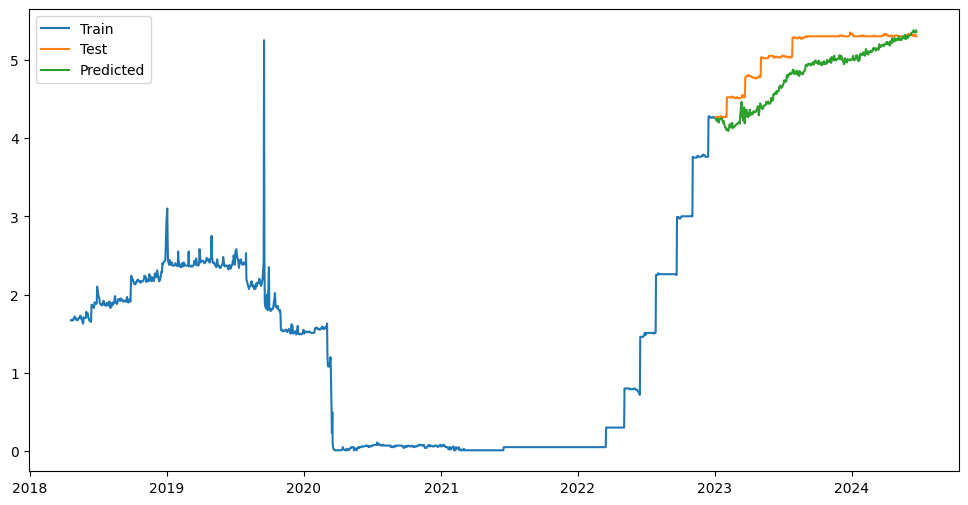

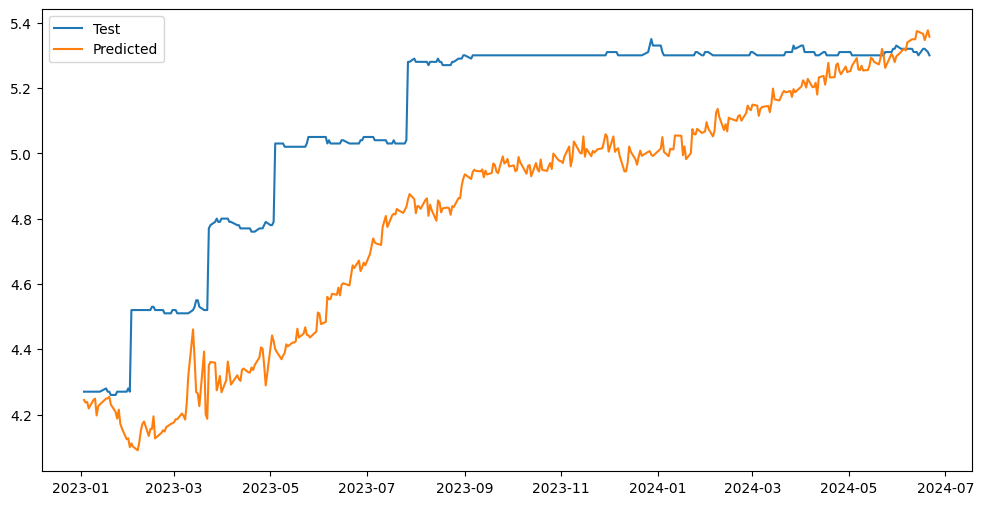

Mean Squared Error: 0.1043
Mean Absolute Error: 0.2805
R2 Score: -0.0001
Root Mean Squared Error: 0.323


In [ ]:
# Split into train and test

train = df_prepared_nona[:'2022-12-31']
test = df_prepared_nona['2023-01-01':]

# Split into X & y

# y_train = train['Rate (%) - Second Differenced']
# X_train = train.drop(columns=['Rate (%) - Second Differenced'])
# y_test = test['Rate (%) - Second Differenced']
# X_test = test.drop(columns=['Rate (%) - Second Differenced'])

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])


# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model definition

model = SARIMAX(y_train, exog= X_train_scaled, order= (2,1,1), seasonal_order= (2,1,2,12)) # order was (1,1,1) seasonal_order was (0,0,0,0)
# (p, d, q) = (1,1,2) so dependent is differenced 1 (d) time, dependent lag 1 (p), error lag 2 (q)
# (P, D, Q, s) = (2,1,1,6) seasonal differencing 1 (D) time on a period of 6 (s), seasonal lag 2 (P), moving average 1 (Q)

model_fit = model.fit(disp=False)
print(model_fit.summary())

# Prediction and plotting

# Predict using the test set
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')

# CONSIDER THE OTHER FEATURES THAT WERE DROPPED INSTEAD